## Add Starting Pitching to Model
- In the last notebook we augmented our dataframe to include various features based on the starting pitcher's performance
- Now we will add these features in to see how much improvement we get to our model.
- NOTE: have modified the previous notebook (added "Strt_" to feature names)

In [1]:
# Uncomment if you need to install any of the following packages
# !pip install lightgbm
# !pip install ml_insights --upgrade
# !pip install structureboost

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [8]:
df=pd.read_csv('df_bp5.csv')

/var/folders/4n/m6y9jtrx6m1_59wkdvlnxsm80000gn/T/ipykernel_2385/700438063.py:1: DtypeWarning: Columns (13,14,15,19,85,87,198) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('df_bp5.csv')


## Begin Modeling

In [9]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1980) & (df.season<=2016)]
df_valid = df[(df.season>=2017) & (df.season<=2018)]
df_test = df[df.season>=2021]

In [10]:
hv_mean = df_train.home_victory.mean()

## First - just add in ERA and WHIP over last 35 games

In [11]:
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_35_h','Strt_ERA_35_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v', 
]
target = 'home_victory'

In [12]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()


In [13]:
X_train.shape, X_valid.shape, X_test.shape, 

((81093, 8), (4861, 8), (4856, 8))

In [14]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

[LightGBM] [Info] Number of positive: 43708, number of negative: 37385
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 81093, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.538986 -> initscore=0.156262
[LightGBM] [Info] Start training from score 0.156262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [15]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [16]:
# previous model gave 0.6830
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6748508816497436, 0.6905005945172807)

In [17]:
log_loss(y_test,df_test.implied_prob_h_mid)

0.6674197609198098

In [18]:
np.round([.6904 - .6675, .6904-.6830, .6904-.6747], decimals=4)

array([0.0229, 0.0074, 0.0157])

In [19]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

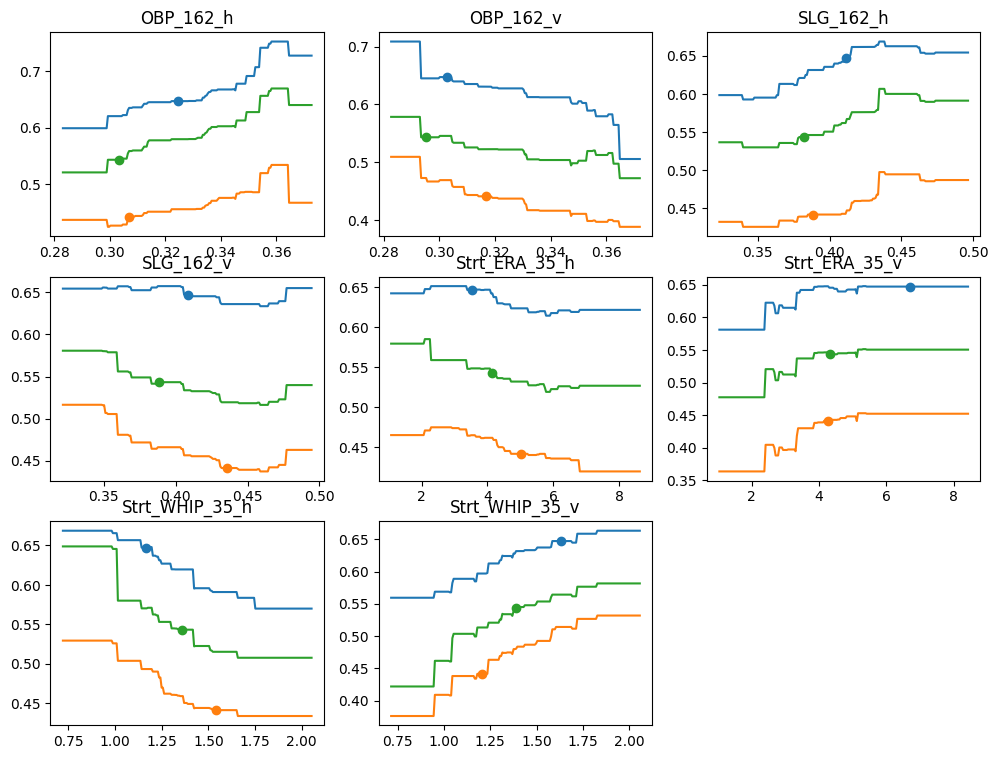

In [20]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

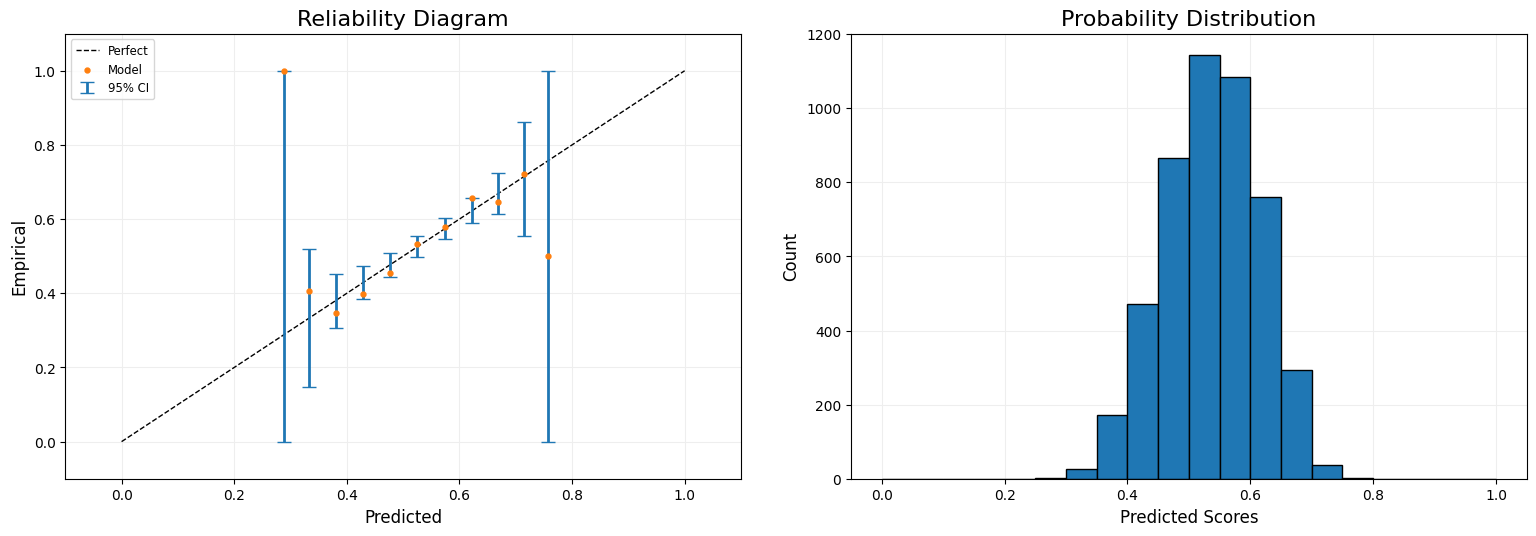

In [21]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [22]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [23]:
# This shows for each game, how the different features affected 
sv_lgbm.head(5).round(3)

,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,Strt_ERA_35_h,Strt_ERA_35_v,Strt_WHIP_35_h,Strt_WHIP_35_v,Intercept
0,-0.077,0.076,0.074,0.022,0.059,0.022,0.170,0.062,0.159
1,-0.091,0.044,0.045,0.026,0.027,-0.093,0.104,-0.235,0.159
2,-0.019,0.021,0.090,-0.065,-0.062,-0.084,0.047,-0.229,0.159
3,-0.117,0.020,-0.046,-0.046,0.037,-0.091,0.024,-0.153,0.159
4,-0.077,0.021,0.044,-0.073,0.032,-0.018,0.166,-0.365,0.159


In [24]:
df_test.pitcher_start_name_v.iloc[4]

'Kenta Maeda'

In [25]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept         0.158645
Strt_WHIP_35_h    0.095402
Strt_WHIP_35_v    0.093447
OBP_162_v         0.074947
OBP_162_h         0.072328
SLG_162_h         0.053296
Strt_ERA_35_h     0.048205
Strt_ERA_35_v     0.041796
SLG_162_v         0.040097
dtype: float64

## Let's add in a few more pitching features

In [26]:
# Add in SO% and "Modified Slugging Against"
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_35_h','Strt_ERA_35_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_SO_perc_35_h', 'Strt_SO_perc_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
]
target = 'home_victory'

In [27]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()


In [28]:
X_train.shape, X_valid.shape, X_test.shape, 

((81093, 14), (4861, 14), (4856, 14))

In [29]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

[LightGBM] [Info] Number of positive: 43708, number of negative: 37385
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 81093, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.538986 -> initscore=0.156262
[LightGBM] [Info] Start training from score 0.156262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [30]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [45]:
from sklearn.metrics import accuracy_score

log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [51]:
preds_lgbm = pd.DataFrame(preds_lgbm, columns=['accuracy'])
preds_lgbm['accuracy'] = (preds_lgbm['accuracy'] > 0.5).astype(int)
y_test = pd.DataFrame(y_test, columns=['home_victory'])

print(accuracy_score(y_test, preds_lgbm))
# log_loss(y_test, hv_mean*np.ones(len(y_test)))
vegas_prob_df = pd.DataFrame(hv_mean * np.ones(len(y_test)), columns=['vegas_prob'])
vegas_prob_df['vegas_prob'] = (vegas_prob_df['vegas_prob'] > 0.5).astype(int)
vegas_prob_df.head()
print(accuracy_score(y_test, vegas_prob_df))


0.5848434925864909
0.5364497528830313


In [27]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

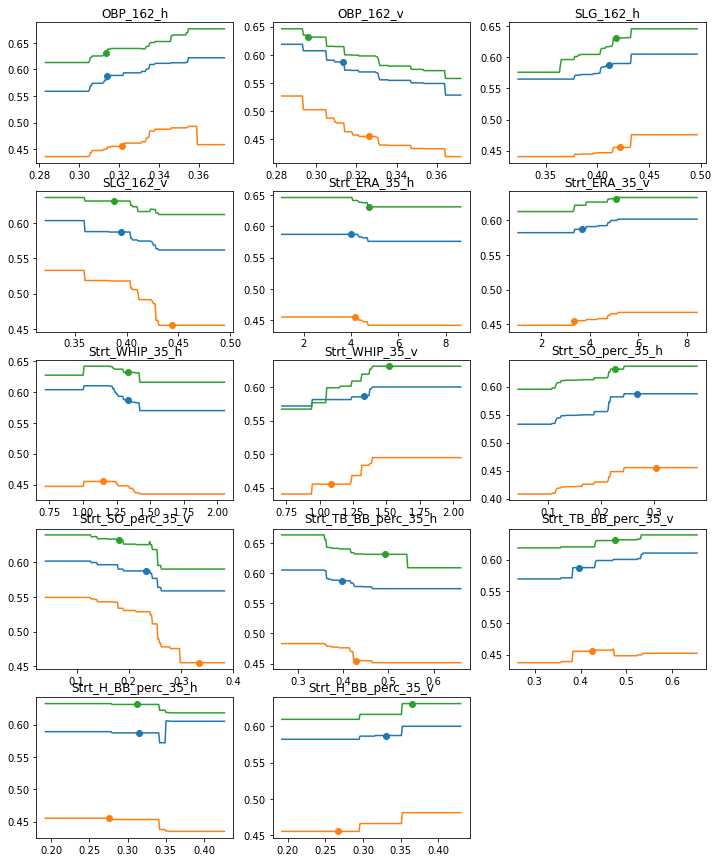

In [28]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

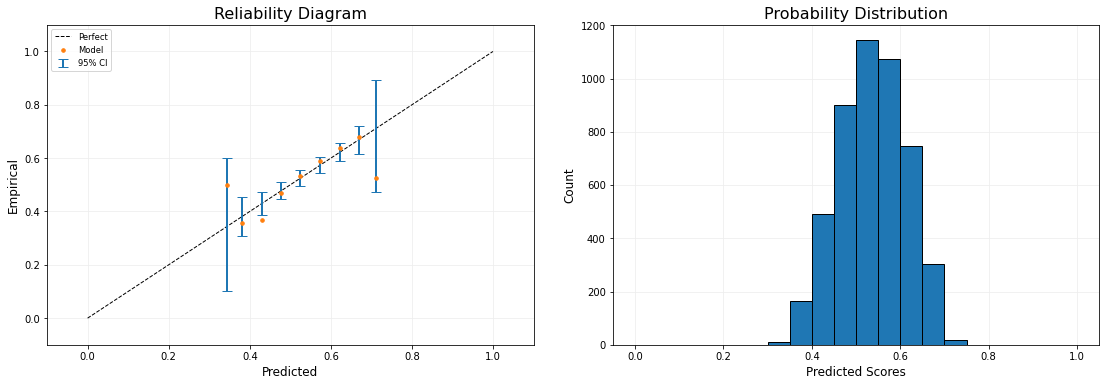

In [29]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [30]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [31]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.156905
Strt_SO_perc_35_v       0.084315
Strt_SO_perc_35_h       0.071734
OBP_162_v               0.067599
OBP_162_h               0.056671
Strt_WHIP_35_v          0.050667
Strt_WHIP_35_h          0.046770
SLG_162_h               0.041868
Strt_TB_BB_perc_35_h    0.036163
SLG_162_v               0.034773
Strt_H_BB_perc_35_v     0.020719
Strt_ERA_35_v           0.020455
Strt_ERA_35_h           0.019549
Strt_TB_BB_perc_35_v    0.017436
Strt_H_BB_perc_35_h     0.014587
dtype: float64

In [32]:
## Let's add in the 10 game lookback features
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_35_h','Strt_ERA_35_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_SO_perc_35_h', 'Strt_SO_perc_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_ERA_10_h','Strt_ERA_10_v',
            'Strt_WHIP_10_h','Strt_WHIP_10_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Strt_TB_BB_perc_10_h', 'Strt_TB_BB_perc_10_v',
]
target = 'home_victory'

In [33]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()


In [34]:
X_train.shape, X_valid.shape, X_test.shape, 

((85933, 20), (3327, 20), (4852, 20))

In [35]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.688888
[20]	valid_0's binary_logloss: 0.687744
[30]	valid_0's binary_logloss: 0.686825
[40]	valid_0's binary_logloss: 0.685676
[50]	valid_0's binary_logloss: 0.684757
[60]	valid_0's binary_logloss: 0.683896
[70]	valid_0's binary_logloss: 0.682991
[80]	valid_0's binary_logloss: 0.682292
[90]	valid_0's binary_logloss: 0.68174
[100]	valid_0's binary_logloss: 0.681131
[110]	valid_0's binary_logloss: 0.680548
[120]	valid_0's binary_logloss: 0.680048
[130]	valid_0's binary_logloss: 0.679609
[140]	valid_0's binary_logloss: 0.679092
[150]	valid_0's binary_logloss: 0.678684
[160]	valid_0's binary_logloss: 0.678307
[170]	valid_0's binary_logloss: 0.677937
[180]	valid_0's binary_logloss: 0.677669
[190]	valid_0's binary_logloss: 0.677382
[200]	valid_0's binary_logloss: 0.677131
[210]	valid_0's binary_logloss: 0.676814
[220]	valid_0's binary_logloss: 0.676605
[230]	valid_0's binary_logloss: 0.676397
[240]	

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [36]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [37]:
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6748118015338063, 0.6904929601621782)

In [38]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

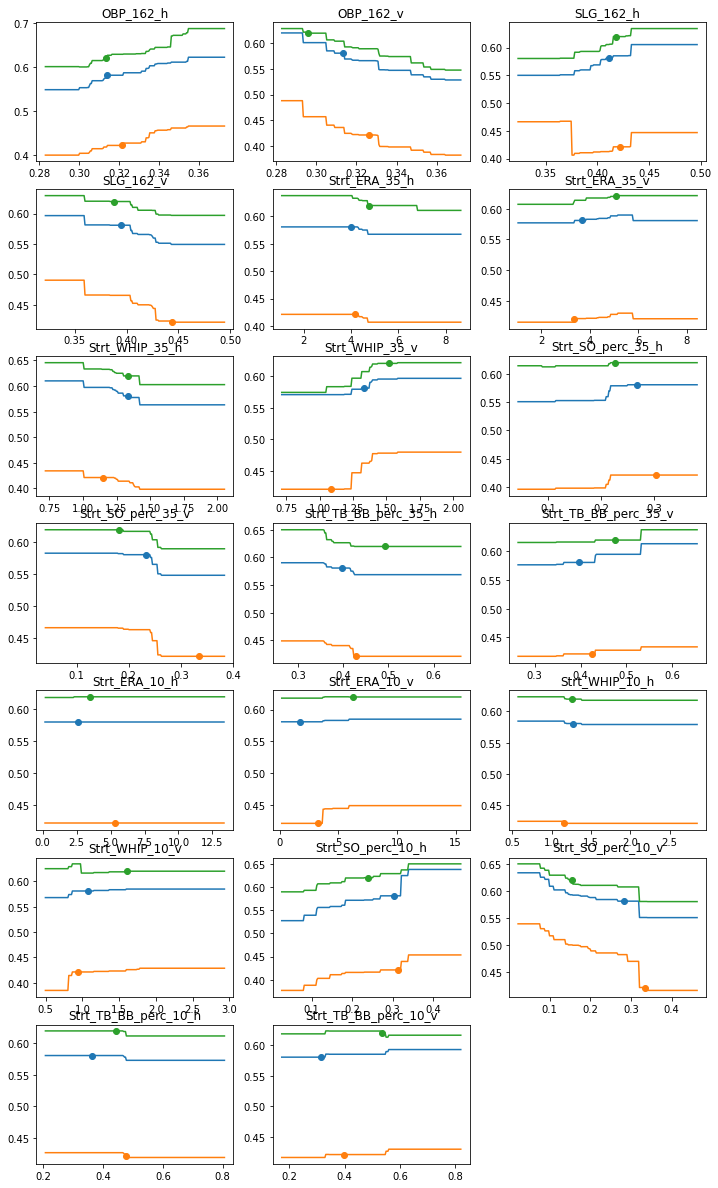

In [39]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

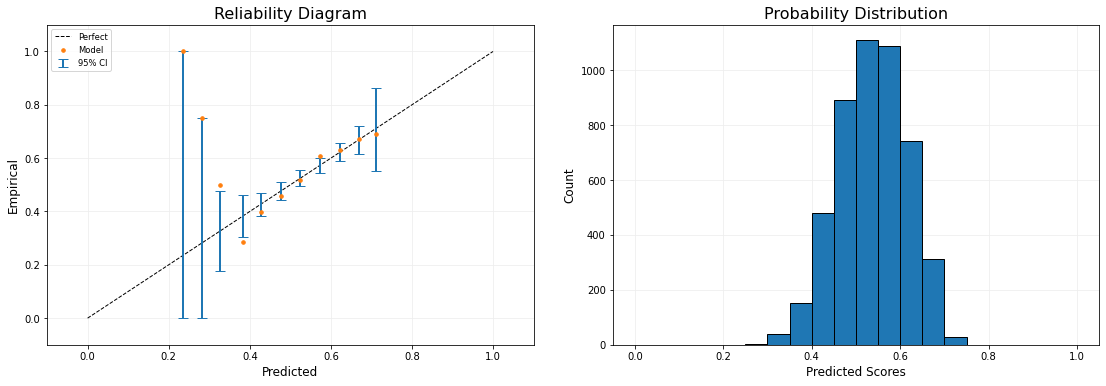

In [40]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [41]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [42]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.157151
OBP_162_v               0.068841
OBP_162_h               0.061437
Strt_WHIP_35_v          0.059590
Strt_SO_perc_10_v       0.055916
Strt_SO_perc_10_h       0.053644
Strt_WHIP_35_h          0.046413
SLG_162_h               0.043847
Strt_SO_perc_35_v       0.039195
Strt_SO_perc_35_h       0.035598
SLG_162_v               0.034940
Strt_TB_BB_perc_35_h    0.028470
Strt_ERA_35_h           0.022081
Strt_TB_BB_perc_35_v    0.015991
Strt_ERA_35_v           0.015178
Strt_ERA_10_v           0.014622
Strt_TB_BB_perc_10_h    0.014202
Strt_WHIP_10_h          0.010703
Strt_WHIP_10_v          0.007033
Strt_TB_BB_perc_10_v    0.004523
Strt_ERA_10_h           0.000287
dtype: float64

In [43]:
# Choose the best window size for each metric, drop ERA
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            
]
target = 'home_victory'

In [44]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()


In [45]:
X_train.shape, X_valid.shape, X_test.shape, 

((85933, 10), (3327, 10), (4852, 10))

In [46]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.688866
[20]	valid_0's binary_logloss: 0.687717
[30]	valid_0's binary_logloss: 0.686827
[40]	valid_0's binary_logloss: 0.68605
[50]	valid_0's binary_logloss: 0.685209
[60]	valid_0's binary_logloss: 0.68441
[70]	valid_0's binary_logloss: 0.683598
[80]	valid_0's binary_logloss: 0.682848
[90]	valid_0's binary_logloss: 0.682167
[100]	valid_0's binary_logloss: 0.681659
[110]	valid_0's binary_logloss: 0.681072
[120]	valid_0's binary_logloss: 0.680481
[130]	valid_0's binary_logloss: 0.679909
[140]	valid_0's binary_logloss: 0.679469
[150]	valid_0's binary_logloss: 0.679086
[160]	valid_0's binary_logloss: 0.678744
[170]	valid_0's binary_logloss: 0.678455
[180]	valid_0's binary_logloss: 0.678197
[190]	valid_0's binary_logloss: 0.677867
[200]	valid_0's binary_logloss: 0.677601
[210]	valid_0's binary_logloss: 0.677419
[220]	valid_0's binary_logloss: 0.677165
[230]	valid_0's binary_logloss: 0.677001
[240]	v

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [47]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [48]:
# now about 4 bps worse than previous model..
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6749901646725965, 0.6904929601621782)

In [49]:
log_loss(y_test,df_test.implied_prob_h_mid)

0.6675629431340582

In [50]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

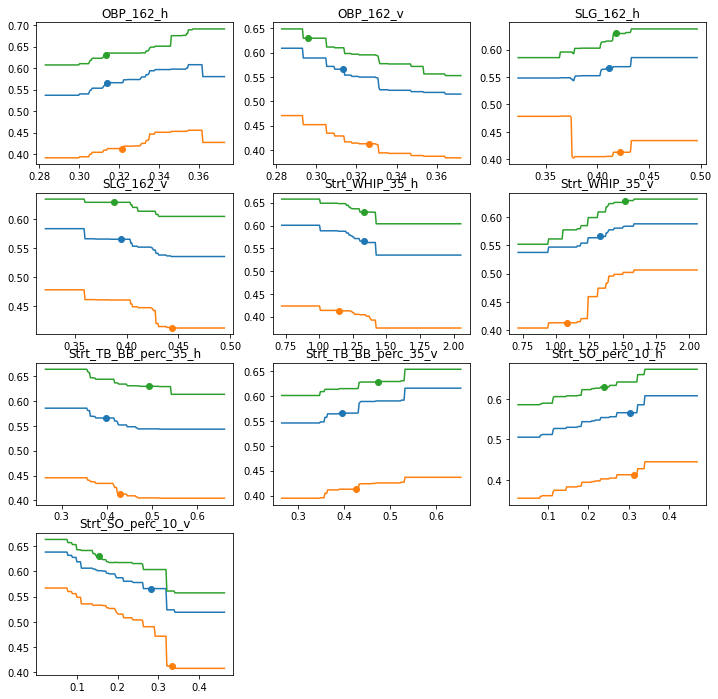

In [51]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

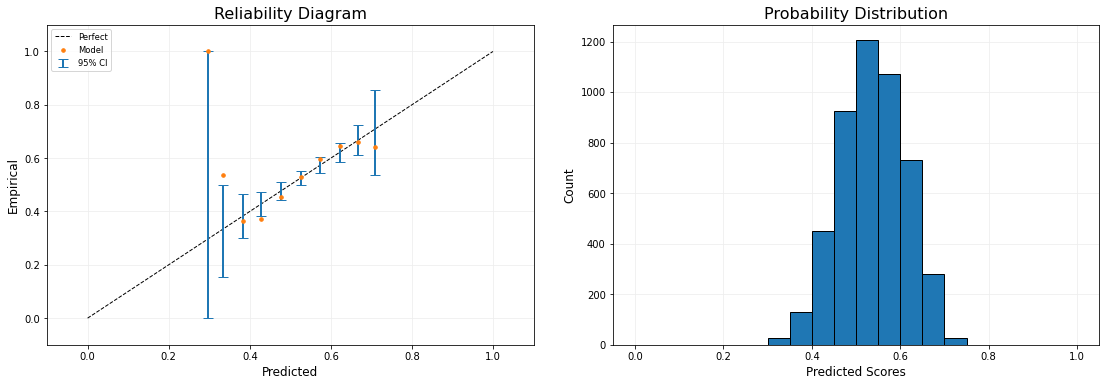

In [52]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [53]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [54]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.157073
Strt_SO_perc_10_v       0.082279
Strt_SO_perc_10_h       0.078344
Strt_WHIP_35_v          0.077848
OBP_162_v               0.068678
Strt_WHIP_35_h          0.066446
OBP_162_h               0.061356
SLG_162_h               0.041615
Strt_TB_BB_perc_35_h    0.040650
SLG_162_v               0.035725
Strt_TB_BB_perc_35_v    0.031188
dtype: float64

## How much do these differences in log loss really mean?
When model A does a few bps better than model B in log loss,  how should we think about that?
- Is it a meaningful improvement?
- How do we know it is not just "luck of the draw" of the test set

We'll run some quick simulations to build our intuition about this.

In [56]:
# Simulate a test set (with given "true" probabilities) and compare two models, 
def ll_dist(probvec_true, probvec_mod1, probvec_mod2, num_trials):
    llvec_mod1 = np.zeros(num_trials)
    llvec_mod2 = np.zeros(num_trials)
    for i in range(num_trials):
        sim_outcome = np.random.binomial(n=1, p=probvec_true)
        llvec_mod1[i] = log_loss(sim_outcome, probvec_mod1)
        llvec_mod2[i] = log_loss(sim_outcome, probvec_mod2)
    return(llvec_mod1 - llvec_mod2)

In [57]:
pv_true = df_test.implied_prob_h_mid
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.04, .04, len(pv_true))

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)

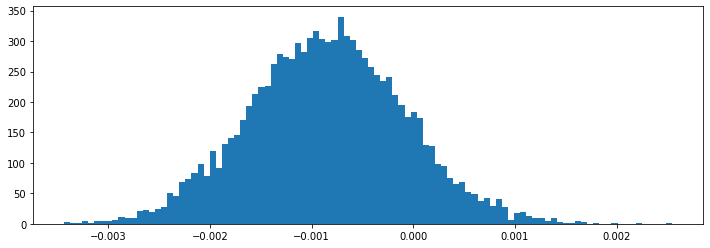

In [58]:
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

In [59]:
pv_true = np.repeat(df_test.implied_prob_h_mid,10)
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.04, .04, len(pv_true))

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)

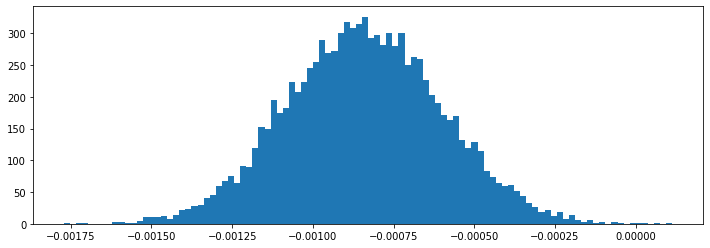

In [60]:
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

In [61]:
pv_true = df_test.implied_prob_h_mid
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.10, .10, len(pv_true))

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)

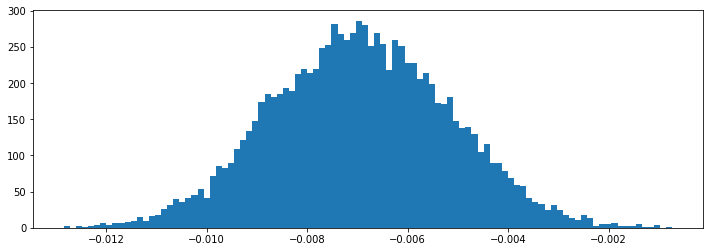

In [62]:
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

# Conclusions
- ## Could be that 5-10 bps improvement is meaningful!
- ## Variation due to test set size is considerable
- ## Not a simple matter to increase test set size in this problem
- ## For now, still need to improve beyond minor optimizations

# Next Steps
- ## Have nothing about the quality of the bullpen
- ## Bullpen is more meaningful in recent years, as starting pitchers work fewer innings
- ## Could cause an issue with "model drift" - something to explore later on

- ## We don't account for the specific hitting lineup - would need individual batter data

- ## We have nothing about fielding

- ## Several additional sources of model drift
    - ## Rule changes about infield positioning
    - ## Pitching clock
    - ## NL now has a DH